In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-2fe7e6a2-696e-6da9-ccd2-1a336002c27d)


In [ ]:
# study_nlp.ipynb

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [3]:
# dev.txt : validation 데이터
# test.txt : 테스트 데이터
# train.txt : 학습 데이터 

In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
import os
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
# 여기까지 해서 데이터가 준비!
# 데이터가 준비되면 데이터 살펴보기를 우선 실시!

In [7]:
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
train_lines = get_lines(data_dir + "/" + "train.txt")

In [9]:
type(train_lines), len(train_lines)

(list, 210040)

In [10]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} 
        target_text_split = abstract_line.split("\t") 
        line_data["target"] = target_text_split[0] 
        line_data["text"] = target_text_split[1].lower() 
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data) 
    else:
      abstract_lines += line
  
  return abstract_samples    

In [14]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/" + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/" + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/" + "test.txt")

CPU times: user 541 ms, sys: 92.4 ms, total: 634 ms
Wall time: 636 ms


In [15]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [16]:
type(train_samples), type(val_samples), type(test_samples)

(list, list, list)

In [17]:
train_samples[0], type(train_samples[0])

({'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 dict)

In [18]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [19]:
train_df.head(24)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [20]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [21]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

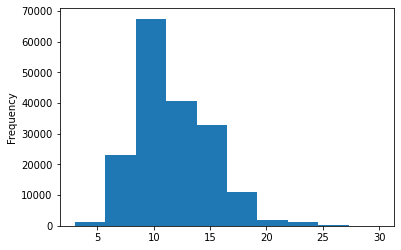

In [22]:
train_df.total_lines.plot.hist()

In [23]:
train_df["text"], type(train_df["text"])

(0         to investigate the efficacy of @ weeks of dail...
 1         a total of @ patients with primary knee oa wer...
 2         outcome measures included pain reduction and i...
 3         pain was assessed using the visual analog pain...
 4         secondary outcome measures included the wester...
                                 ...                        
 180035    for the absolute change in percent atheroma vo...
 180036    for pav , a significantly greater percentage o...
 180037    both strategies had acceptable side effect pro...
 180038    compared with standard statin monotherapy , th...
 180039    ( plaque regression with cholesterol absorptio...
 Name: text, Length: 180040, dtype: object, pandas.core.series.Series)

In [24]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [25]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [26]:
# METHODS => 0, RESULTS => 1 ... 라벨을 할 수도 있다
# Tensorflow의 CategoricalCrossentropy loss 함수의 경우 one hot encoding한 라벨을 선호

In [27]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(
    train_df["target"].to_numpy().reshape(-1, 1)
)
val_labels_one_hot = one_hot_encoder.fit_transform(
    val_df["target"].to_numpy().reshape(-1, 1)
)
test_labels_one_hot = one_hot_encoder.fit_transform(
    test_df["target"].to_numpy().reshape(-1, 1)
)


In [28]:
type(train_labels_one_hot), train_labels_one_hot, train_labels_one_hot.shape

(numpy.ndarray, array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), (180040, 5))

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(
    train_df["target"].to_numpy().reshape(-1, 1)
)
val_labels_encoded = label_encoder.fit_transform(
    val_df["target"].to_numpy().reshape(-1, 1)
)
test_labels_encoded = label_encoder.fit_transform(
    test_df["target"].to_numpy().reshape(-1, 1)
)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
train_labels_encoded, type(train_labels_encoded), train_labels_encoded.shape

(array([3, 2, 2, ..., 4, 1, 1]), numpy.ndarray, (180040,))

In [31]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [32]:
# Model 0 : 가장 기본이 되는 간단한 모델

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(
    X = train_sentences, 
    y = train_labels_encoded    
)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [33]:
model_0.score(
    X = val_sentences,
    y = val_labels_encoded
)

0.7218323844829869

In [34]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [38]:
from helper_functions import calculate_results

In [39]:
baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds 
)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [40]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [41]:
train_sentences[0].split()

['to',
 'investigate',
 'the',
 'efficacy',
 'of',
 '@',
 'weeks',
 'of',
 'daily',
 'low-dose',
 'oral',
 'prednisolone',
 'in',
 'improving',
 'pain',
 ',',
 'mobility',
 ',',
 'and',
 'systemic',
 'low-grade',
 'inflammation',
 'in',
 'the',
 'short',
 'term',
 'and',
 'whether',
 'the',
 'effect',
 'would',
 'be',
 'sustained',
 'at',
 '@',
 'weeks',
 'in',
 'older',
 'adults',
 'with',
 'moderate',
 'to',
 'severe',
 'knee',
 'osteoarthritis',
 '(',
 'oa',
 ')',
 '.']

In [42]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <a list of 10 Patch objects>)

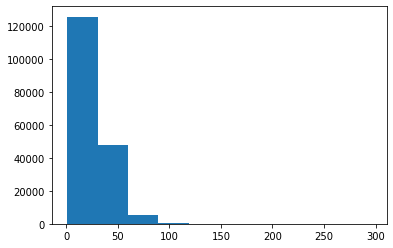

In [43]:
import matplotlib.pyplot as plt

plt.hist(sent_lens)

In [44]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [45]:
max(sent_lens)

296

In [46]:
max_tokens = 68000

In [47]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = output_seq_len
)

In [48]:
train_sentences

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [49]:
text_vectorizer.adapt(train_sentences)

In [50]:
import random

target_sentence = random.choice(train_sentences)
print(f"Text: \n{target_sentence}")
print(f"\nText를 만드는 token의 갯수: \n{len(target_sentence.split())}")
print(f"\nVector로 만들어진 Text: \n{text_vectorizer([target_sentence])} {text_vectorizer([target_sentence]).shape}")

Text: 
the bravo study is a non-inferiority trial comparing echocardiographic optimization of atrioventricular ( av ) and interventricular ( vv ) delay with an alternative method using non-invasive blood pressure monitoring that can be automated to consume less staff resources .

Text를 만드는 token의 갯수: 
40

Vector로 만들어진 Text: 
[[    2 40615    17    20     8   731    32   582  3880  4191     4  8514
   6235     3 15871 10483  2201     7    26   775   363    59  1903   107
    200   607    28   171    36  1863     6  5226   211  1284  1799     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]] (1, 55)


In [51]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(len(rct_20k_text_vocab))
print(rct_20k_text_vocab[:5])
print(rct_20k_text_vocab[-5:])

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [52]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

In [53]:
token_embed = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True,
    name = "token_embedding"
)

In [54]:
target_sentence = random.choice(train_sentences)
print(target_sentence)

vectorized_sentence = text_vectorizer([target_sentence])
print(vectorized_sentence)

embedded_sentence = token_embed(vectorized_sentence)
print(embedded_sentence, embedded_sentence.shape)

to compare open surgical circumcision with suturing v. the unicirc disposable instrument plus tissue adhesive .
tf.Tensor(
[[    6   226   655   306  5450     7  6251  1010     2 21442  4903  2363
    231   669  4051     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)
tf.Tensor(
[[[ 0.01836893  0.04309529 -0.02698287 ... -0.03570021 -0.00609894
   -0.04239274]
  [ 0.04347037 -0.02898852  0.00894539 ... -0.02150482  0.03681041
   -0.00056813]
  [ 0.01221313  0.00214084  0.01952973 ...  0.04296906 -0.04731021
   -0.00512858]
  ...
  [-0.04873376 -0.02101088 -0.04451995 ...  0.04665763 -0.03552494
   -0.01205643]
  [-0.04873376 -0.02101088 -0.04451995 ...  0.04665763 -0.03552494
   -0.01205643]
  [-0.04873376 -0.02101088 -0.04451995 ...  0.04665763 -0.03552494
   -0.0

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)

In [56]:
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [57]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [59]:
# Model 1 : Conv1D
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(
    64, 
    kernel_size = 5, 
    padding = "same", 
    activation = "relu"
)(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_1.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [60]:
model_1_history = model_1.fit(
    train_dataset,
    epochs = 3,
    validation_data = valid_dataset
)

Epoch 1/3
5627/5627 [==============================] - 107s 13ms/step - loss: 0.6155 - accuracy: 0.7761 - val_loss: 0.5345 - val_accuracy: 0.8107
Epoch 2/3
5627/5627 [==============================] - 75s 13ms/step - loss: 0.4499 - accuracy: 0.8425 - val_loss: 0.5320 - val_accuracy: 0.8119
Epoch 3/3
5627/5627 [==============================] - 75s 13ms/step - loss: 0.3680 - accuracy: 0.8740 - val_loss: 0.5682 - val_accuracy: 0.8066


In [61]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5682 - accuracy: 0.8066


[0.5682251453399658, 0.8066331148147583]

In [62]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[6.2287062e-01, 9.2661437e-03, 2.8533483e-01, 4.9398977e-02,
        3.3129469e-02],
       [6.0212040e-01, 6.9561310e-02, 3.1695946e-03, 3.1516057e-01,
        9.9881496e-03],
       [8.8631645e-02, 4.1294242e-03, 1.4443495e-03, 9.0572035e-01,
        7.4334312e-05],
       ...,
       [2.6062460e-07, 3.6861500e-06, 8.6706650e-04, 1.2587199e-07,
        9.9912888e-01],
       [9.0505503e-02, 4.6666184e-01, 2.2936861e-01, 2.3436833e-02,
        1.9002724e-01],
       [3.0095014e-03, 9.9467540e-01, 1.9944606e-03, 9.0165358e-06,
        3.1160400e-04]], dtype=float32)

In [63]:
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [64]:
model_1_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_1_preds
)
model_1_results

{'accuracy': 80.66331259102344,
 'f1': 0.8041113644811568,
 'precision': 0.8035993711452165,
 'recall': 0.8066331259102344}

In [65]:
model_1.save('model_1')

INFO:tensorflow:Assets written to: model_1/assets


In [66]:
!pip install tensorflow_hub

In [67]:
# Model 2: 
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    name = "universal_sentence_encoder"
)


In [68]:
target_sentence = random.choice(train_sentences)
print(target_sentence)

embedded_sentence = tf_hub_embedding_layer([target_sentence])
print(embedded_sentence, embedded_sentence.shape)

the preliminary efficacy of a behavioral exercise intervention that incorporated features designed to address prior limitations was tested in a randomized controlled trial ( rct ) .
tf.Tensor(
[[ 0.02628203  0.00624766 -0.02439131 -0.06192023 -0.04610136  0.05099985
   0.06853289  0.01142077  0.0323591   0.0223497   0.05661435  0.00484617
   0.07908117  0.05433241  0.04994208 -0.05014649 -0.04530161  0.07787211
  -0.05046463 -0.03409067 -0.07622778  0.02159076 -0.07205953 -0.02832015
  -0.01248121 -0.0278596  -0.02561597  0.05505658 -0.01576349  0.03427489
   0.06721136  0.07450464 -0.05128055  0.06641739 -0.00252769  0.03564944
  -0.02196565 -0.04591368 -0.02560108 -0.0287199  -0.03191927  0.02162842
  -0.02565719  0.03413089 -0.04611791  0.0555586   0.00024688  0.03463645
   0.04940718 -0.01792318  0.02488482 -0.04318192 -0.05226419 -0.03404308
  -0.02155731  0.06467803  0.02180769 -0.04000994  0.08134837  0.03594964
  -0.02257142  0.04926481  0.03843627  0.0437623  -0.00411028 -0.03

In [69]:
inputs = layers.Input(shape=[], dtype=tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = "relu")(pretrained_embedding)

outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [70]:
model_2.fit(
    train_dataset,
    epochs = 3,
    validation_data = valid_dataset
)

Epoch 1/3
5627/5627 [==============================] - 106s 18ms/step - loss: 0.7305 - accuracy: 0.7206 - val_loss: 0.6600 - val_accuracy: 0.7474
Epoch 2/3
5627/5627 [==============================] - 103s 18ms/step - loss: 0.6380 - accuracy: 0.7582 - val_loss: 0.6248 - val_accuracy: 0.7623
Epoch 3/3
5627/5627 [==============================] - 103s 18ms/step - loss: 0.6034 - accuracy: 0.7721 - val_loss: 0.6097 - val_accuracy: 0.7679


In [71]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.6097 - accuracy: 0.7679


[0.6096607446670532, 0.7679067850112915]

In [72]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[5.65256357e-01, 3.18878859e-01, 2.76402367e-04, 1.09391928e-01,
        6.19651191e-03],
       [4.40590113e-01, 4.42942113e-01, 1.47620891e-03, 1.13650605e-01,
        1.34098262e-03],
       [5.65394223e-01, 2.98361015e-02, 3.74198593e-02, 3.52653772e-01,
        1.46960951e-02],
       ...,
       [6.34009601e-04, 3.58426449e-04, 1.80611331e-02, 8.49454373e-05,
        9.80861485e-01],
       [6.26498461e-03, 6.47711009e-02, 8.36465359e-02, 1.72214652e-03,
        8.43595207e-01],
       [1.02787744e-02, 9.80373621e-01, 8.84579960e-03, 3.41804189e-05,
        4.67637321e-04]], dtype=float32)

In [73]:
model_2_pred = tf.argmax(model_2_pred_probs, axis = 1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [74]:
model_2_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_2_pred
)
model_2_results

{'accuracy': 76.79067920031775,
 'f1': 0.7636011713319736,
 'precision': 0.7657767304014846,
 'recall': 0.7679067920031776}

In [75]:
# 지금까지 우리는 token을 단어 단위 whitespace로 만들었습니다.
# 이번에는 character 수준으로 token화하는 방법을 알아보겠습니다.

In [76]:
def split_chars(text):
    return " ".join(list(text))

In [77]:
random_training_sentence = random.choice(train_sentences)
split_chars(random_training_sentence)

'e a c h   p e r i o d   w a s   s e p a r a t e d   b y   a   @ - d a y   w a s h o u t   p e r i o d   .'

In [78]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5], len(train_chars)

(['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
  'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
  'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s  

In [79]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

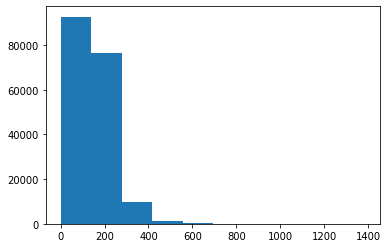

In [80]:
import matplotlib.pyplot as plt

plt.hist(char_lens)

In [81]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [82]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [83]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKENS,
    output_sequence_length = output_seq_char_len,
    standardize = "lower_and_strip_punctuation",
    name = "char_vectorizer"
)

In [84]:
char_vectorizer.adapt(train_chars)

In [85]:
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
print(char_vocab[-5:])

28
['', '[UNK]', 'e', 't', 'i']
['k', 'x', 'z', 'q', 'j']


In [86]:
random_train_chars = random.choice(train_chars)
print(random_train_chars)
print(len(random_train_chars.split()))

vectorized_chars = char_vectorizer([random_train_chars])
print(vectorized_chars)
print(len(vectorized_chars[0]))

a d d i t i o n a l   a n a l y s e s   i n   m i n d f u l n e s s - r e l a t e d   t r a i n i n g   c o m p l i a n c e   s u b g r o u p s   (   h i g h   a n d   l o w   c o m p l i a n c e   v e r s u s   t h e   c o n t r o l   g r o u p   a s   a   r e f e r e n c e   )   a n d   s u b g r o u p s   b a s e d   o n   b a s e l i n e   w o r k   e n g a g e m e n t   s c o r e s   s h o w e d   n o   s i g n i f i c a n t   d i f f e r e n c e s   e i t h e r   .
205
tf.Tensor(
[[ 5 10 10  4  3  4  7  6  5 12  5  6  5 12 19  9  2  9  4  6 15  4  6 10
  17 16 12  6  2  9  9  8  2 12  5  3  2 10  3  8  5  4  6  4  6 18 11  7
  15 14 12  4  5  6 11  2  9 16 22 18  8  7 16 14  9 13  4 18 13  5  6 10
  12  7 20 11  7 15 14 12  4  5  6 11  2 21  2  8  9 16  9  3 13  2 11  7
   6  3  8  7 12 18  8  7 16 14  5  9  5  8  2 17  2  8  2  6 11  2  5  6
  10  9 16 22 18  8  7 16 14  9 22  5  9  2 10  7  6 22  5  9  2 12  4  6
   2 20  7  8 23  2  6 18  5 18  2 15  2  6  3  9 11  7  8  2  9 

In [87]:
char_embed = layers.Embedding(
    input_dim = NUM_CHAR_TOKENS,
    output_dim = 25,
    mask_zero = True,
    name = "char_embed"
)

In [88]:
print(random_train_chars)

char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(char_embed_example)
print(char_embed_example.shape)

a d d i t i o n a l   a n a l y s e s   i n   m i n d f u l n e s s - r e l a t e d   t r a i n i n g   c o m p l i a n c e   s u b g r o u p s   (   h i g h   a n d   l o w   c o m p l i a n c e   v e r s u s   t h e   c o n t r o l   g r o u p   a s   a   r e f e r e n c e   )   a n d   s u b g r o u p s   b a s e d   o n   b a s e l i n e   w o r k   e n g a g e m e n t   s c o r e s   s h o w e d   n o   s i g n i f i c a n t   d i f f e r e n c e s   e i t h e r   .
tf.Tensor(
[[[ 0.01731827  0.04929915 -0.02719247 ...  0.01721564  0.02128825
    0.02801119]
  [ 0.04001616  0.0296682   0.026125   ... -0.03308518 -0.00632062
    0.00336448]
  [ 0.04001616  0.0296682   0.026125   ... -0.03308518 -0.00632062
    0.00336448]
  ...
  [-0.02926883 -0.02835225 -0.01566099 ...  0.00936747  0.03197959
    0.02559152]
  [-0.02926883 -0.02835225 -0.01566099 ...  0.00936747  0.03197959
    0.02559152]
  [-0.02926883 -0.02835225 -0.01566099 ...  0.00936747  0.03197959
    0.02559152]]], shape=

In [89]:
# Model 3 : Conv1D
inputs = layers.Input(shape=(1, ), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(
    64, 
    kernel_size = 5, 
    padding = "same", 
    activation = "relu"
)(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_conv1D_char_embedding")

model_3.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_________________________________

In [90]:
train_char_dataset = tf.data.Dataset.from_tensor_slices(
    (train_chars, train_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices(
    (val_chars, val_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [91]:
model_3_history = model_3.fit(
    train_char_dataset,
    epochs = 3,
    validation_data = val_char_dataset
)

Epoch 1/3
5627/5627 [==============================] - 51s 9ms/step - loss: 1.3144 - accuracy: 0.4479 - val_loss: 1.2479 - val_accuracy: 0.4855
Epoch 2/3
5627/5627 [==============================] - 50s 9ms/step - loss: 1.2188 - accuracy: 0.4985 - val_loss: 1.1704 - val_accuracy: 0.5213
Epoch 3/3
5627/5627 [==============================] - 50s 9ms/step - loss: 1.1333 - accuracy: 0.5420 - val_loss: 1.0820 - val_accuracy: 0.5659


In [92]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.2406378 , 0.28836337, 0.19250515, 0.2386883 , 0.03980534],
       [0.12012222, 0.21424592, 0.17809191, 0.05664716, 0.43089283],
       [0.17402948, 0.2150819 , 0.27782106, 0.21257223, 0.1204953 ],
       ...,
       [0.01566014, 0.04452564, 0.19166166, 0.00486706, 0.7432856 ],
       [0.06709933, 0.15571655, 0.5135955 , 0.07345045, 0.19013813],
       [0.28394818, 0.2897599 , 0.16242415, 0.07672095, 0.18714681]],
      dtype=float32)

In [93]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 2, 1])>

In [94]:
model_3_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_3_preds
)
model_3_results

{'accuracy': 56.59340659340659,
 'f1': 0.5366533342809425,
 'precision': 0.5357347606009724,
 'recall': 0.5659340659340659}

In [95]:
# Model 4 : token embedding + charater embedding (hybrid embedding layer)
token_inputs = layers.Input(shape=[], dtype=tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(
    inputs = token_inputs,
    outputs = token_output
)

char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(
    inputs = char_inputs,
    outputs = char_bi_lstm
)

token_char_concat = layers.Concatenate(name = "token_char_hybrid")(
    [token_model.output, char_model.output]
)

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

model_4 = tf.keras.Model(
    inputs = [token_model.input, char_model.input], 
    outputs = output_layer, 
    name = "model_4_token_and_char_embeddings"
)

model_4.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [96]:
!pip install keras-utils
!pip install pydot

  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=f2ad2ff38714dc0b2e3fdbca9479b8f73722dcd6924d57d94b0d8170991e147e
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras-utils


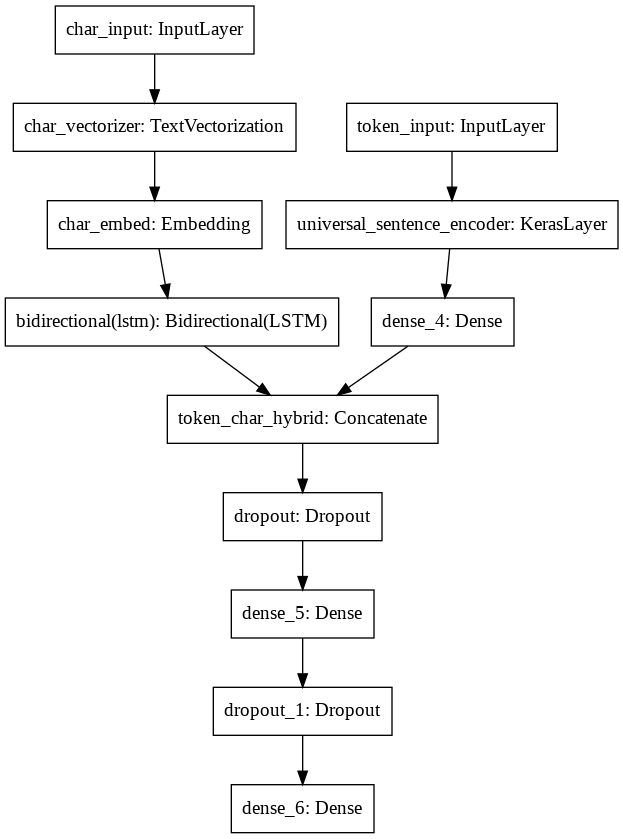

In [97]:
from keras.utils.vis_utils import plot_model
plot_model(model_4, to_file="model_4.png")

In [98]:
train_char_token_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars)
)
train_char_token_labels = tf.data.Dataset.from_tensor_slices(
    (train_labels_one_hot)
)
train_char_token_dataset = tf.data.Dataset.zip(
    (train_char_token_data, train_char_token_labels)
)

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [99]:
val_char_token_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars)
)
val_char_token_labels = tf.data.Dataset.from_tensor_slices(
    (val_labels_one_hot)
)
val_char_token_dataset = tf.data.Dataset.zip(
    (val_char_token_data, val_char_token_labels)
)

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [100]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [101]:
model_4_history = model_4.fit(
    train_char_token_dataset,
    epochs = 3,
    validation_data = val_char_token_dataset
)

Epoch 1/3
5627/5627 [==============================] - 727s 127ms/step - loss: 0.7523 - accuracy: 0.7113 - val_loss: 0.6192 - val_accuracy: 0.7640
Epoch 2/3
5627/5627 [==============================] - 712s 127ms/step - loss: 0.6676 - accuracy: 0.7487 - val_loss: 0.5905 - val_accuracy: 0.7738
Epoch 3/3
5627/5627 [==============================] - 712s 127ms/step - loss: 0.6414 - accuracy: 0.7588 - val_loss: 0.5708 - val_accuracy: 0.7840


In [102]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 49s 51ms/step - loss: 0.5708 - accuracy: 0.7840


[0.57079017162323, 0.7840262055397034]

In [103]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[5.5923438e-01, 2.3731819e-01, 1.3801757e-03, 1.9851726e-01,
        3.5500126e-03],
       [4.5471308e-01, 3.7706542e-01, 3.5009226e-03, 1.6099675e-01,
        3.7238493e-03],
       [4.4867504e-01, 2.2496828e-03, 1.0129088e-02, 5.3862971e-01,
        3.1649505e-04],
       ...,
       [7.0040383e-05, 4.5075678e-04, 1.0228507e-02, 1.8401453e-05,
        9.8923230e-01],
       [1.4704414e-02, 1.0620120e-01, 1.2273312e-01, 6.5365178e-03,
        7.4982482e-01],
       [1.6905542e-02, 9.7645378e-01, 5.1455745e-03, 6.3204783e-04,
        8.6298224e-04]], dtype=float32)

In [104]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [105]:
model_4_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_4_preds
)
model_4_results

{'accuracy': 78.40262147491063,
 'f1': 0.7800966511155079,
 'precision': 0.7834853664543072,
 'recall': 0.7840262147491063}

In [ ]:
# Model 5 : token embedding + character embedding (여기까지 해서는 그다지 성능 향상이 없었다!) + positional embedding

In [106]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [107]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

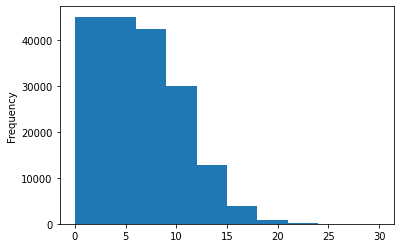

In [108]:
train_df.line_number.plot.hist()

In [109]:
train_line_numbers_one_hot = tf.one_hot(
    train_df["line_number"].to_numpy(), depth = 15
)

val_line_numbers_one_hot = tf.one_hot(
    val_df["line_number"].to_numpy(), depth = 15
)

test_line_numbers_one_hot = tf.one_hot(
    test_df["line_number"].to_numpy(), depth = 15
)

In [115]:
train_line_numbers_one_hot, train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 

In [117]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

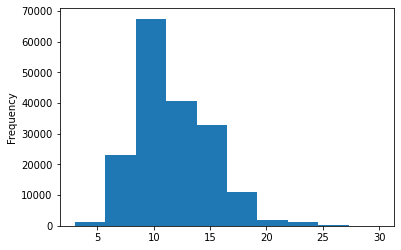

In [118]:
train_df.total_lines.plot.hist()

In [119]:
np.percentile(train_df.total_lines, 98)

20.0

In [120]:
train_total_lines_one_hot = tf.one_hot(
    train_df["total_lines"].to_numpy(), depth = 20
)

val_total_lines_one_hot = tf.one_hot(
    val_df["total_lines"].to_numpy(), depth = 20
)

test_total_lines_one_hot = tf.one_hot(
    test_df["total_lines"].to_numpy(), depth = 20
)

In [121]:
train_total_lines_one_hot, train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

In [139]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(
    inputs = token_inputs,
    outputs = token_embeddings
)

char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(
    inputs = char_inputs,
    outputs = char_bi_lstm
)

line_number_inputs = layers.Input(shape=(15, ), dtype = tf.int32, name = "line_number_input")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(
    inputs = line_number_inputs,
    outputs = x
)

total_lines_inputs = layers.Input(shape=(20, ), dtype = tf.int32, name = "total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(
    inputs = total_lines_inputs,
    outputs = y
)

combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embedding")(
    [token_model.output, char_model.output]
)
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name = "token_char_positional_embedding")(
    [line_number_model.output, total_lines_model.output, z]
)
output_layer = layers.Dense(5, activation="softmax", name = "output_layer")(z)

model_5 = tf.keras.Model(
    inputs = [line_number_model.input, total_lines_model.input, token_model.input, char_model.input], 
    outputs = output_layer, 
    name = "model_5_token_and_char_positional_embeddings"
)

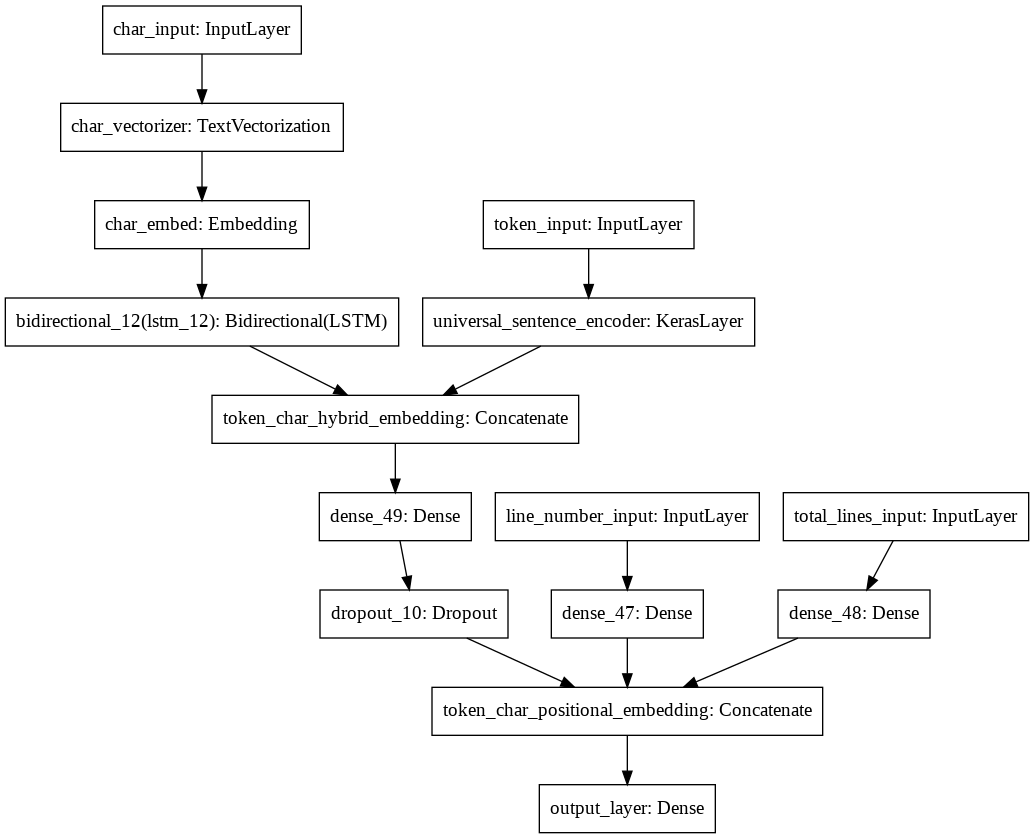

In [140]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [141]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fcb8b4bf990> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fcba4c6eb10> True
<keras.engine.input_layer.InputLayer object at 0x7fcb8bae5750> True
<keras.layers.embeddings.Embedding object at 0x7fcba4c430d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fcbab201090> False
<keras.layers.wrappers.Bidirectional object at 0x7fcb8bf8cb50> True
<keras.layers.merge.Concatenate object at 0x7fcb8c281250> True
<keras.engine.input_layer.InputLayer object at 0x7fcb8bf71fd0> True
<keras.engine.input_layer.InputLayer object at 0x7fcb8aebae50> True
<keras.layers.core.Dense object at 0x7fcb8c180a90> True
<keras.layers.core.Dense object at 0x7fcb8c2fb2d0> True
<keras.layers.core.Dense object at 0x7fcb8aeba3d0> True
<keras.layers.core.Dropout object at 0x7fcb8b520b10> True
<keras.layers.merge.Concatenate object at 0x7fcb8c271c10> True
<keras.layers.core.Dense object at 0x7fcb8b7253d0> True


In [ ]:
# [0.0, 0.0, 1.0, 0.0. 0.0] : 예측 결과
# [0.01, 0.01, 0.096, 0.01, 0.01] 로 좀더 유연하게 결과를 예측하겠다. 


In [143]:
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [144]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices(
    (train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars)
)
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot
)
train_pos_char_token_dataset = tf.data.Dataset.zip(
    (train_pos_char_token_data, train_pos_char_token_labels)
)
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices(
    (val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars)
)
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(
    val_labels_one_hot
)
val_pos_char_token_dataset = tf.data.Dataset.zip(
    (val_pos_char_token_data, val_pos_char_token_labels)
)
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [145]:
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
history_model_5 = model_5.fit(
    train_pos_char_token_dataset,
    epochs = 3,
    validation_data = val_pos_char_token_dataset
)

Epoch 1/3
 178/5627 [..............................] - ETA: 11:28 - loss: 1.2438 - accuracy: 0.6211